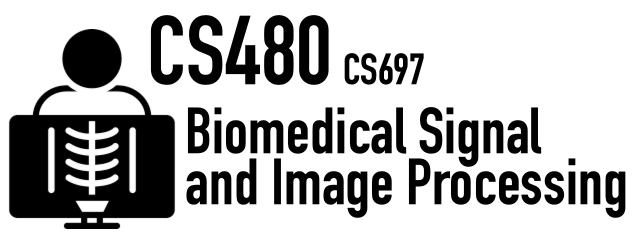
#Assignment 6

In [ ]:
# In this assignment, we will train a U-Net classifer to detect mitochondria
# in electron microscopy images!

In [ ]:
### IMPORTANT ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [1]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load the unet tensorflow code
!pip install git+https://github.com/jakeret/unet.git

  Cloning https://github.com/jakeret/unet.git to /tmp/pip-req-build-yc9ebj42
  Running command git clone -q https://github.com/jakeret/unet.git /tmp/pip-req-build-yc9ebj42
  Created wheel for unet: filename=unet-0.0.post0.dev81+gf557a51-py2.py3-none-any.whl size=25658 sha256=d5a0ff20f037ab265d5b28a3549276fc4a4fdc4db377987ac345f1820f7da096
  Stored in directory: /tmp/pip-ephem-wheel-cache-3vs6lqym/wheels/f5/38/c8/8f0a157cfd7616cc1a24811a52b9a669c0ee8fccc9f99d3cbc
Successfully built unet


In [3]:
# .. and use it!
# Note: There are a ton of U-Net implementations but this one is easier to use!
import unet

**Task 1**: Study the unet circle example and learn about mitochondria! [15 Points]

In [ ]:
# The unet package allows to train a U-Net classifier with little code.
# As discussed in class, the U-Net can be used to label/segment/annotate images.

In [ ]:
# TODO: Please study the Circles example 
# https://github.com/jakeret/unet/blob/master/notebooks/circles.ipynb

In [ ]:
# TODO: ... and look how the (artificial) dataset is generated
# https://github.com/jakeret/unet/blob/master/src/unet/datasets/circles.py

In [ ]:
# 1) Question
# TODO: Please describe what the U-Net is trained to do.
# TODO: YOUR ANSWER
# The U-Net is supposed to train the circle dataset in which all shapes of circle from original image
# will be masking. From the image masking, U-net model try to predict the shape of circle from original image.
#training set is about 70% total of dataset circles.
#testing set is about 30% total of dataset circles.
#epoch = 5. we will minimize the total cost function in term of accuracy up to 5 iteration epochs.

In [ ]:
# 2) Question
# TODO: In circles.py, what does the following mean:
#     channels = 1
#     classes = 2
#
# TODO: YOUR ANSWER
# class: I guess that this will count how many groups of object you want to classify.
# channels is the way to describe features of each class. OR we can say that it describes the depth of each layer
# For example, RGB channels will include 3 channels.

In [ ]:
# 3) Question
# TODO: What are mitochondria and what is their appearance in
# electron microscopy data?
# Hint: You can validate your answer in Task 4!
#
# TODO: YOUR ANSWER


In [ ]:
# "Mitochondria are membrane-bound cell organelles (mitochondrion, singular) 
# that generate most of the chemical energy needed to power the cell's biochemical reactions. 
# Chemical energy produced by the mitochondria is stored in a small molecule called 
# adenosine triphosphate (ATP). Mitochondria contain their own small chromosomes. Generally, 
# mitochondria, and therefore mitochondrial DNA, are inherited only from the mother."
#Reference: https://www.genome.gov/genetics-glossary/Mitochondria

#electron microscopy(EM) images that allow to identify intracellular mitochondria. 
#In EM images, mitochondria mostly appear sparsely as dark round ellipses or, rarely, irregular structures with sometimes visible inner lamellae

**Task 2**: Setup a datagenerator for mitochondria images! [45 Points]

In [ ]:
# TODO: 
# Download https://cs480.org/data/mito.npz to your computer.
# Then, please upload mito.npz using the file panel on the left.

In [ ]:
# The code below is similar to the circles.py file from Task 1.
# We follow Tensorflow conventions to design a tf.data.Dataset for training
# the U-Net.
#
# TODO: Please add four different data augmentation methods in the code block
# below. (image normalization to 0..1, horizontal data flip, vertical data flip,
# rotation by 90 degrees)
#
# Hint: https://github.com/jakeret/unet/blob/master/src/unet/datasets/oxford_iiit_pet.py#L25

In [18]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_datasets.core import DatasetInfo
from typing import Tuple, List

IMAGE_SIZE = (256, 256)
channels = 1
classes = 2

def load_data(count:int, splits:Tuple[float]=(0.7, 0.2, 0.1), **kwargs) -> List[tf.data.Dataset]:
    return [tf.data.Dataset.from_tensor_slices(_build_samples(int(split * count), **kwargs))
            for split in splits]


def _build_samples(sample_count:int, **kwargs) -> Tuple[np.array, np.array]:

    # here we load the mitochondria data
    loaded = np.load('mito.npz')
    loadedimages = loaded['arr_0'][0].copy()
    loadedmasks = loaded['arr_0'][1].copy()

    # now let's go to numpyland
    images = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
    labels = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 2))
    for i in range(sample_count):
        image, mask = loadedimages[i], loadedmasks[i]

        image = image.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1)).astype(np.float)
        mask = mask.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

        #
        # Normalize the image to 0..1
        #
        image = tf.cast(image, tf.float32) / 255.0
        mask -= 1
      

        #
        # Use Tensorflow to flip the image horizontally
        #
        if tf.random.uniform(()) > 0.5:
          image = tf.image.flip_left_right(image)
          mask = tf.image.flip_left_right(mask)

        #
        # Use Tensorflow to flip the image vertically
        #
        if tf.random.uniform(()) > 0.5:
          image = tf.image.flip_up_down(image)
          mask = tf.image.flip_up_down(mask)
        #
        # Use Tensorflow to rotate the image 90 degrees
        #
        if tf.random.uniform(()) > 0.5:
          image = tf.image.rot90(image)
          mask = tf.image.rot90(mask)


        # augmentation done, let's store the image
        images[i] = image

        # here we split the mask to background and foreground
        fg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        fg[mask == 255] = 1
        bg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
        bg[mask == 0] = 1
        
        labels[i, :, :, 0] = bg[:,:,0]
        labels[i, :, :, 1] = fg[:,:,0]

    return images, labels

**Task 3**: Let's train the U-Net! [25 Points]

In [19]:
#
# We can now create our training, validation, and testing data by calling
# our methods from Task 2.
#
train, val, test = load_data( 660, splits=(0.7, 0.2, 0.1) )

In [20]:
print(train)

<TensorSliceDataset shapes: ((256, 256, 1), (256, 256, 2)), types: (tf.float64, tf.float64)>


In [21]:
print(val)

<TensorSliceDataset shapes: ((256, 256, 1), (256, 256, 2)), types: (tf.float64, tf.float64)>


In [22]:
print(test)

<TensorSliceDataset shapes: ((256, 256, 1), (256, 256, 2)), types: (tf.float64, tf.float64)>


In [ ]:
# 1) Question
# TODO: We have in total 660 images + 660 masks. Based on the code above,
# how many images are used for training alone?
# 70% * 660 = 462 images for training in total, valid : 20% * 660 = 132, and  10% * 660 = 66 images for testing in total
# TODO: YOUR ANSWER

In [23]:
#
# Let's setup the U-Net!
#
LEARNING_RATE = 1e-3

unet_model = unet.build_model(channels=channels,
                              num_classes=classes,
                              layer_depth=5,
                              filters_root=64,
                              padding="same")

unet.finalize_model(unet_model, learning_rate=LEARNING_RATE)

In [24]:
#
# And, let's setup the trainer...
#
trainer = unet.Trainer(checkpoint_callback=False,
                       learning_rate_scheduler=unet.SchedulerType.WARMUP_LINEAR_DECAY,
                       warmup_proportion=0.1,
                       learning_rate=LEARNING_RATE)

In [25]:
#
# ...and train the U-Net for 50 epochs with a batch_size of 10!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use training and validation data.
# Hint 2: This will take roughly 30 minutes!
#
trainer.fit(unet_model , train, val, epochs=50, batch_size=10)

Epoch 1/50
47/47 [==============================] - 104s 2s/step - loss: 0.5443 - categorical_crossentropy: 0.5443 - categorical_accuracy: 0.6586 - mean_iou: 0.2692 - dice_coefficient: 0.5422 - auc_2: 0.8256 - val_loss: 0.2162 - val_categorical_crossentropy: 0.2162 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.3800 - val_dice_coefficient: 0.7719 - val_auc_2: 0.9938
Epoch 2/50
47/47 [==============================] - 99s 2s/step - loss: 0.0870 - categorical_crossentropy: 0.0870 - categorical_accuracy: 0.9210 - mean_iou: 0.4245 - dice_coefficient: 0.8758 - auc_2: 0.9707 - val_loss: 0.1837 - val_categorical_crossentropy: 0.1837 - val_categorical_accuracy: 0.9434 - val_mean_iou: 0.3929 - val_dice_coefficient: 0.7991 - val_auc_2: 0.9932
Epoch 3/50
47/47 [==============================] - 99s 2s/step - loss: 0.0932 - categorical_crossentropy: 0.0932 - categorical_accuracy: 0.9210 - mean_iou: 0.4224 - dice_coefficient: 0.8701 - auc_2: 0.9743 - val_loss: 0.1008 - val_categorical_crossen

**Task 4**: Let's predict mitochondria in the testing data! [15 Points]

In [26]:
# 
# After training, let's try the U-Net on our testing data.
#
# The code below displays the first 10 input images, the original masks by experts, 
# and the predicted masks from the U-Net.

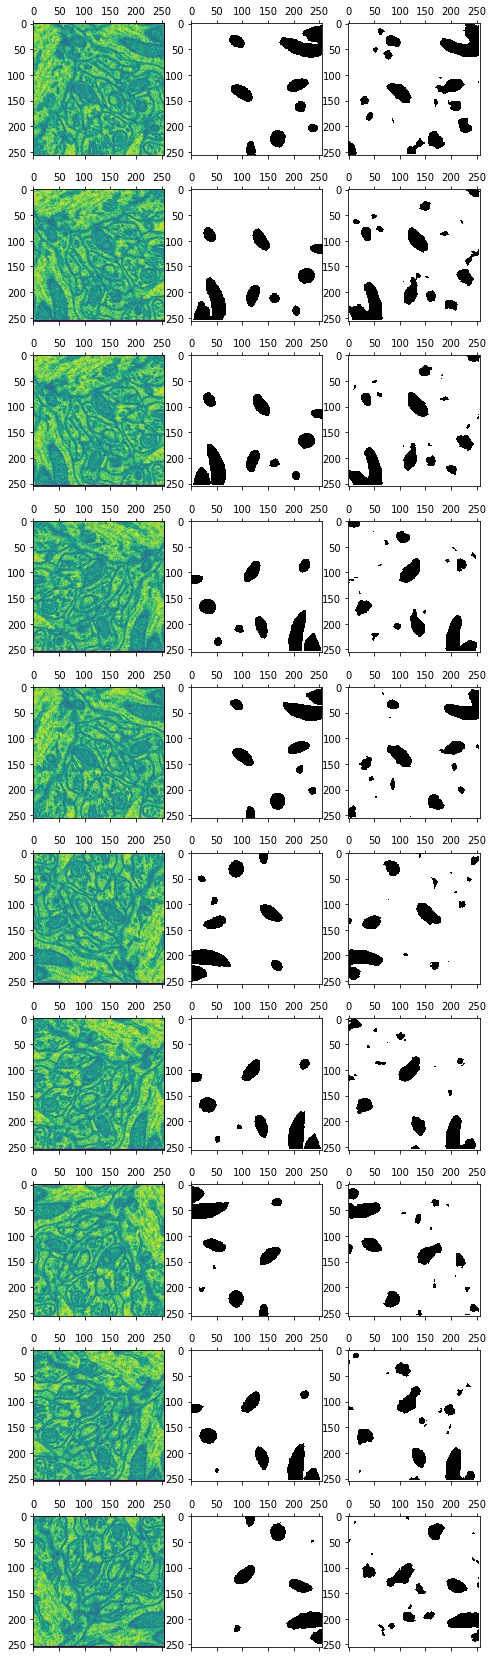

In [27]:
rows = 10
fig, axs = plt.subplots(rows, 3, figsize=(8, 30))
for ax, (image, label) in zip(axs, test.take(rows).batch(1)):
  
  prediction = unet_model.predict(image)
  ax[0].matshow(image[0, :, :, 0])
  ax[1].matshow(label[0, :, :, 1], cmap="gray")
  ax[2].matshow(prediction[0].argmax(axis=-1), cmap="gray")

In [ ]:
# 1) Question
# TODO: Why do we use the prediction[0].argmax(axis=-1) command
# to display the prediction?
# 
# TODO: YOUR ANSWER
#I think that they want to show the class with highly predicted possiblility. Or the best choice of image by the U-net model.
 

In [ ]:
# 2) Question
# TODO: Is the quality of the segmentation good and how could we improve it?
# Hint: Think along the lines of some traditional image processing rather than
# increasing the training data size.
#
# TODO: YOUR ANSWER

In [ ]:
# The quality is  good though.
# The easiest answer is that we will increase the training data + testing data. 
# Beside that, we can increase the accuracy of our model by expanding pixel (more pixels for more accuracy)
# or we can add more layers of each image. 
#The more layers of image and pixels the more precisely we can describe the data. 
# We eventually break image into smaller pieces by more pixels and learn details from that image for our model. 

**Bonus**: Compare against the state-of-the-art literature! [33 Points]

In [ ]:
#
# The following paper also uses a 2D U-Net to detect mitochondria:
# 
# https://danielhaehn.com/papers/?casser2020fast
#

In [ ]:
# 1) Question
#
# TODO: How many learnable parameters does your trained unet_model have?
# Hint: You can use TF's Model Summary function to answer this.
#

In [ ]:
# TODO: YOUR CODE

In [28]:
unet_model.summary()

Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_block_18 (ConvBlock)       (None, None, None, 6 37568       inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, None, None, 6 0           conv_block_18[0][0]              
__________________________________________________________________________________________________
conv_block_19 (ConvBlock)       (None, None, None, 1 221440      max_pooling2d_8[0][0]            
_______________________________________________________________________________________________

In [ ]:
# 2) Question
#
# TODO: How many parameters do Casser et al. use?


In [ ]:
# TODO: YOUR ANSWER

In [ ]:
# " Our input and output sizes are 512 × 512 pixels, respectively, 
# with the input being fed in as a grayscale image and the output being a binary 
# mask, highlighting mitochondria as the posi- tive class"

In [ ]:
# 3) Question
#
# TODO: How did Casser et al. reduce the parameters?
#

In [ ]:
# TODO: YOUR ANSWER

In [ ]:
# " Based on experimental evaluation, we are able to decrease the number of parameters compared 
# to the original U-Net architecture. First, we reduce the number of convolutional filters throughout the network. 
# We then replace transpose convolutions in the decoder with light-weight bilinear upsampling layers that require 
# no parameters. For the encoder, we reach a parameter reduction of 94%, from 19,505,856 to 1,178,480. 
# For the decoder, we reach a 93.6% reduction (from 12,188,545 to 780,053). 
# Lastly, we replace center-cropping from the original U-Net with padding to output densely at full resolution. 
# This modification increases the throughput by an additional 40%""

In [ ]:
# 4) Question
#
# TODO: Why did Casser et al. reduce the parameters?
#

In [ ]:
# TODO: YOUR ANSWER

In [ ]:
# " We trained both our optimized and the original U-Net using the same setup. 
# On the Lucchi++ dataset, we measure a foreground IoU of 0.888 (overall 0.940) compared to 0.887 (overall 0.939) 
# using the original U-Net, showing equivalent performance. Seemingly the learning capacity of the original U-Net 
# is larger than needed for this task. To investigate, we inspect the trained models for permanently inactive 
# (‘dead‘) ReLU activations and find that in practice, 33.53% of the filters in the original U-Net stay inactive 
# and waste significant compute. In contrast, our optimized U-Net reaches 99.7% utilization"

#The U-Net wil reaches 99.7% utilization.

In [ ]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#